# Modelisations de la distribution des variables magnitudes (class)et profondeur (depth)

## Table of Contents

* [Chargement des librairies necessaires](#chapter1)
* [Import des donneés et Analyse](#chapter2)


## Chargement des librairies necessaires <a class="anchor" id="chapter1"></a>

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# librairie pour l'estimation des paramètres
import scipy
import scipy.stats

## Import des donneés et Analyse <a class="anchor" id="chapter1"></a>

In [2]:
# Get the data
#r = requests.get('https://raw.githubusercontent.com/eupho73/TER-BNN/main/data/data.csv')
r = requests.get('https://raw.githubusercontent.com/eupho73/TER-BNN/main/data/nn/eq_1960_2022.csv')
# Save the data
with open("eq_1960_2022.csv", 'wb') as f:
#with open("eq_data.csv", 'wb') as f:
    f.write(r.content)
    
#open the data   
data=pd.read_csv("eq_1960_2022.csv")


In [3]:
print("les dimensions", data.shape) 
data.head()

les dimensions (34068, 5)


,time,latitude,longitude,depth,mag
0,2021-12-01,35.2280,141.4204,10.00,4.7
1,2021-12-01,35.2774,141.5336,10.00,4.7
2,2021-12-01,33.7690,137.1036,362.75,4.0
3,2021-12-01,35.2014,141.4165,10.00,4.5
4,2021-12-01,35.1430,141.3281,10.00,4.9


In [4]:
data.describe() # Des stats rapides sur les données

,latitude,longitude,depth,mag
count,34068.000000,34068.000000,34068.000000,34068.000000
mean,37.691623,141.543955,70.260528,4.538313
std,4.033038,3.675254,93.952011,0.523106
min,30.001000,129.004000,0.000000,1.800000
25%,34.743750,140.094000,29.600000,4.200000
50%,37.277000,141.822000,35.400000,4.500000
75%,41.083150,143.357000,64.300000,4.800000
max,45.999000,148.999000,620.200000,9.100000


C:\Users\khali\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\khali\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


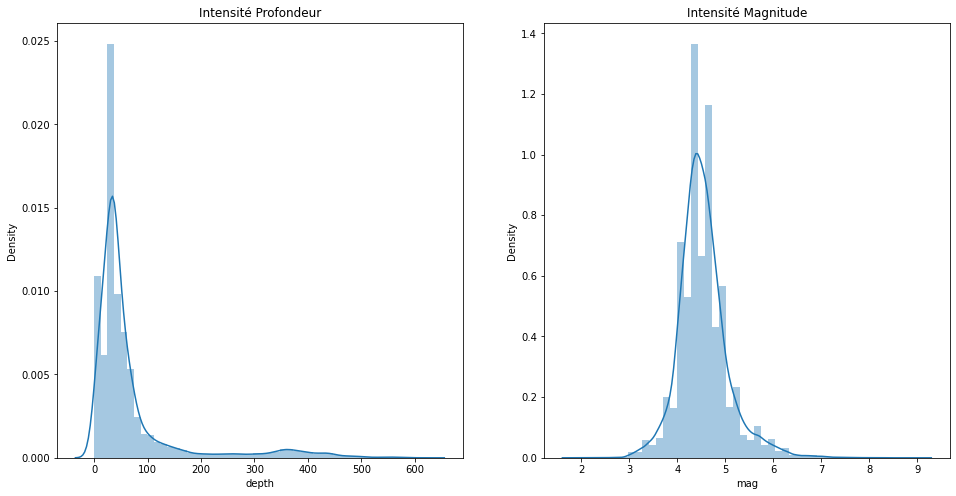

In [5]:
plt.figure(figsize = (16,8))
plt.subplot(121)
sns.distplot(data['depth'])
plt.title("Intensité Profondeur")
plt.subplot(122)
sns.distplot(data['mag'])
plt.title("Intensité Magnitude")
plt.show()

## Diviser en zone

**Cette fois, je me refère au decoupage de Damien, vu que le but est de lui donner une base de comparaison de ces sorties BNN**

In [6]:
from collections import namedtuple

Coords = namedtuple("Coords", "lat_min lat_max lon_min lon_max")
zones = {"A": Coords(41, 46, 140, 146), "B": Coords(37, 41, 138, 142), "C": Coords(34, 37, 137, 141), "D": Coords(33, 37, 133, 137), "E": Coords(31, 36, 129, 133), "F": Coords(38, 41, 142, 144), "G": Coords(36, 38, 141, 143)}

def to_5_zone(lat: float, lon: float):
    """Convert coordinates to a zone number according to the map arrangement above"""
    for zone, coord in zones.items():
        if (coord.lat_min <= lat <= coord.lat_max) & (coord.lon_min <= lon <= coord.lon_max):
            return zone
    return 0
data["zone"] = data.apply(lambda x: to_5_zone(x['latitude'], x['longitude']), axis=1)

In [7]:
data.tail()

,time,latitude,longitude,depth,mag,zone
34063,1960-03-23,39.137,143.598,25.0,5.9,F
34064,1960-03-23,39.146,143.564,25.0,5.8,F
34065,1960-03-23,39.235,143.303,15.0,6.2,F
34066,1960-02-04,38.667,143.014,25.0,6.1,F
34067,1960-01-31,33.093,134.885,20.0,6.3,D


Dans le cadre du pricing d'un cat bond, on va s'interesser aux EQ capable de declencher un sinistre. Ici on choisit ceux dont les magnitudes sont superieurs à 4.5 en référence à ce tableau.
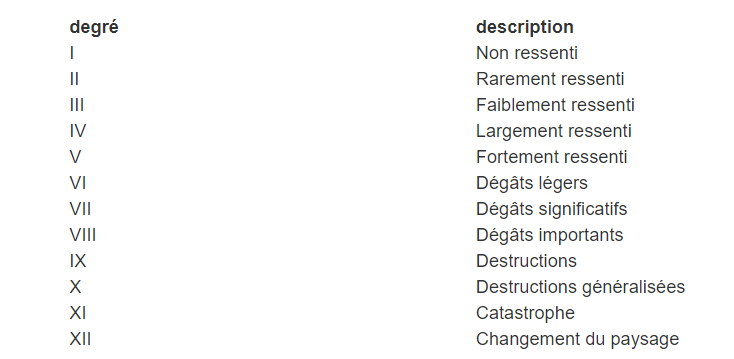

In [8]:
# On supprime les observations in-interessantes ( qui ne sont pas les zones definies de A à G et les magn sont inferieurs 4.5)

data = data[(data.mag >= 4.5) & (data.zone != 0)]
#data = data[data.zone != 0]
data.head()

,time,latitude,longitude,depth,mag,zone
13,2021-12-01,36.1875,140.0911,51.68,5.0,C
20,2021-12-02,37.7216,141.7845,57.22,4.8,B
23,2021-12-02,35.5460,139.0340,26.64,4.5,C
24,2021-12-02,45.8325,142.5511,314.40,4.6,A
26,2021-12-03,33.8337,135.0775,12.08,5.2,D


On extrait les années et mois de la variable time pour 2 variables sur lesquels nous allons effectuer un groupby (ref Damien dt = mois)

In [9]:
import datetime as dt 
data['time']= pd.to_datetime(data['time'])
#pd.DatetimeIndex(data['time']).year
data['year']= (data['time']).apply(lambda x: x.year)
data['month']= (data['time']).apply(lambda x: x.month)

In [10]:
data.head()

,time,latitude,longitude,depth,mag,zone,year,month
13,2021-12-01,36.1875,140.0911,51.68,5.0,C,2021,12
20,2021-12-02,37.7216,141.7845,57.22,4.8,B,2021,12
23,2021-12-02,35.5460,139.0340,26.64,4.5,C,2021,12
24,2021-12-02,45.8325,142.5511,314.40,4.6,A,2021,12
26,2021-12-03,33.8337,135.0775,12.08,5.2,D,2021,12


# Modélisation Intensité 

**Calcul du max de mag par mois et par zone ( ref to the article of J. Shao et al. "Catastrophe risk bonds with applications
to earthquakes")**
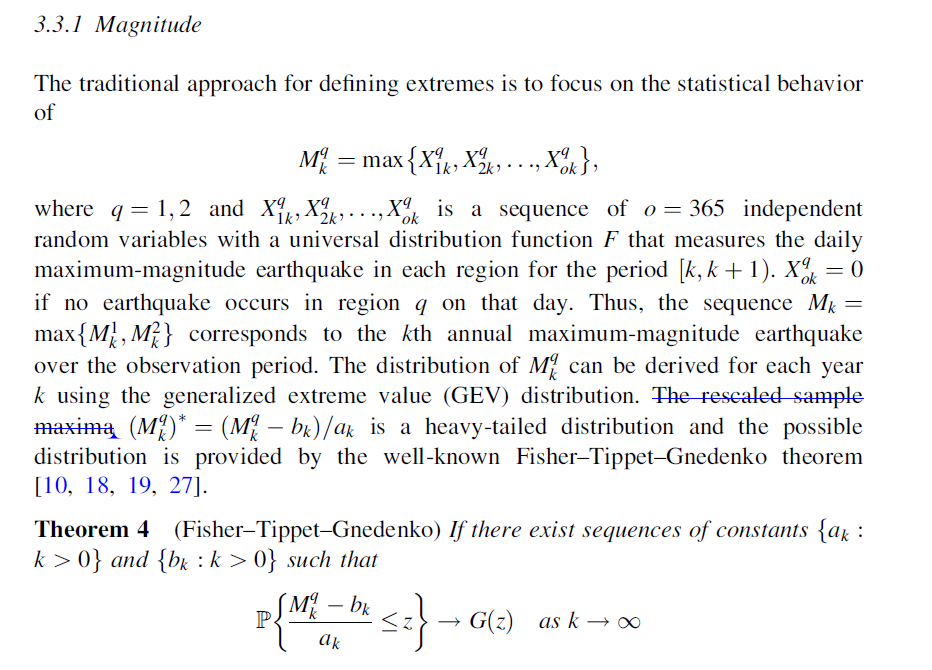

In [11]:
temp = data.groupby(['year','month','zone'], as_index = False)

df_max_per_month_per_zone = temp.mag.max()
df_max_per_month_per_zone.rename({"mag":"max_mag"},axis=1,inplace=True)
df_max_per_month_per_zone.tail() 



,year,month,zone,max_mag
2874,2021,12,A,5.1
2875,2021,12,B,5.1
2876,2021,12,C,5.0
2877,2021,12,D,5.2
2878,2021,12,G,4.6


 max_mag correspond à la variable 
$
M_{k}^{q}=\max \left\{X_{1 k}^{q}, X_{2 k}^{q}, \ldots, X_{o k}^{q}\right\}
$
Où $q=1,2,\ldots,7 $ et $X_{1 k}^{q}, X_{2 k}^{q}, \ldots, X_{o k}^{q}$ est une séquence de $o=30$ observations independentes entre le mois k et k+1.

### Pour estimer les paramètres

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html

On crée un dictionnaire dicos_zone qui regroupe les zones et observations associées

In [12]:
dicos_zones_max_mag ={name:data for name, data in zip(zones.keys(),
                                              [df_max_per_month_per_zone[df_max_per_month_per_zone['zone']== k] 
                                               
                                               for k in df_max_per_month_per_zone['zone'].unique()])}

In [13]:
dicos_zones_max_mag['A']['max_mag']

0       6.3
11      5.6
14      6.8
20      6.2
35      6.3
       ... 
2824    4.7
2846    4.7
2853    4.5
2864    4.7
2877    5.2
Name: max_mag, Length: 200, dtype: float64

In [14]:
from scipy.stats import genextreme as gnx 

In [15]:
param = gnx.fit(dicos_zones_max_mag['A']['max_mag'])

In [16]:

loc = param[-2]
scale = param[-1]
arg = param[:-2]

y, x= np.histogram(dicos_zones_max_mag['A']['max_mag'], bins=500, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
pdf = gnx.pdf(x, *arg, loc=loc, scale=scale)

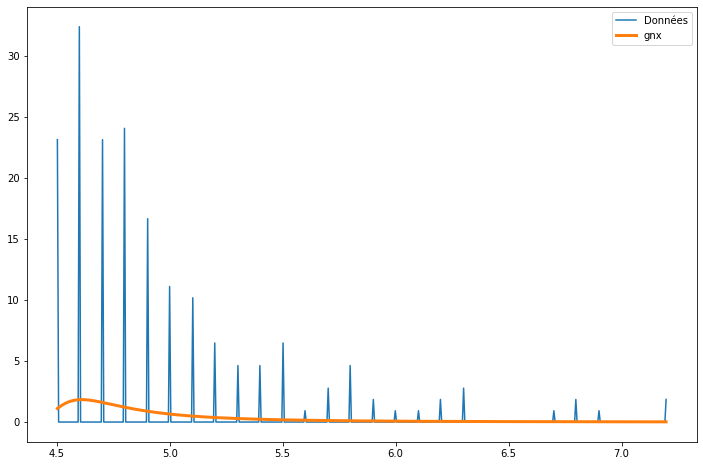

In [17]:
plt.figure(figsize=(12,8))
plt.plot(x, y, label="Données")
plt.plot(x, pdf, label='gnx', linewidth=3)
#plt.title("{}".format(pd.DataFrame(data).columns))
plt.legend(loc='upper right')
plt.show()

Modélisation pas bonne, la loi des valeurs extrêmes "genextreme" dont nous avons estimé les paramètres à partir des observations de notre base ne semble pas bien modéliser ladite. Ce resultat base contredit à ce qui a été décrit dans le doc de CAT BOND PRICING.\
Il existe une explication à cela. En effet, D'après ce théorème decrit dans le doc de pricing :

**Theorem 4 (Fisher-Tippet-Gnedenko) If there exist sequences of constants $\left\{a_{k}\right.$ : $k>0\}$ and $\left\{b_{k}: k>0\right\}$ such that**
$$
\mathbb{P}\left\{\frac{M_{k}^{q}-b_{k}}{a_{k}} \leq z\right\} \rightarrow G(z) \quad \text { as } k \rightarrow \infty
$$
C'est la variable $\left\{\frac{M_{k}^{q}-b_{k}}{a_{k}} \leq z\right\}$ qui suit une loi **genextreme** et non la seule variable $ \left\{ M_{k}^{q} \leq z\right\}$. 
Donc il faudrait determiner les 2 suites $\left\{a_{k}\right.$ : $k>0\}$ and $\left\{b_{k}: k>0\right\}$ afin de transformer notre variable $M_{k}^{q}$

### Calcul de $b_{n}$ et  $a_{n}$

Ce site donne une explication théorique de calcul de bn et a_n.

https://gaz.wiki/wiki/fr/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem

On comprend àprès lecture, que pour pouvoir calculer b_n et a_n, on a besoin d'un paramètre \gamma. Or ce dernier fait partie justement des paramêtres qu'on cherche à  estimer.\
Surement il doit exister d'autres alternatives de calcul de b_n et a_n. A revoir...

**On va réutiliser une fonction que j'avais fait dans l'ancètre code pour trouver la meilleure loi qui modelisation notre variable $ M_{k}^{q}$**

In [18]:
dist_names = ['norm', 'beta','gamma', 'pareto', 't', 'lognorm', 'invgamma', 'invgauss',  'loggamma', 'alpha', 'chi', 'chi2','genextreme']


def estim_best_loi(data, sse_thr = 0.000005):
    # sse_thr = seuil d'acceptation du best
    sse = np.inf
          
    ### Histogramme des données
    y, x = np.histogram(data, bins=50, density=True)
    # Milieu de chaque classe
    x = (x + np.roll(x, -1))[:-1] / 2.0


    # Pour chaque distribution
    for name in dist_names:

        # Modéliser
        dist = getattr(scipy.stats, name)
        param = dist.fit(data)

        # Paramètres
        loc = param[-2]
        scale = param[-1]
        arg = param[:-2]

        # PDF
        pdf = dist.pdf(x, *arg, loc=loc, scale=scale)
        # SSE
        model_sse = np.sum((y - pdf)**2)

        # Si le SSE est ddiminué, enregistrer la loi
        if model_sse < sse :
            best_pdf = pdf
            sse = model_sse
            best_loc = loc
            best_scale = scale
            best_arg = arg
            best_name = name

        # Si en dessous du seuil, quitter la boucle
        if model_sse < sse_thr :
            break
            
    ### Affichage de la meilleure loi avec paramètre associé
    
    plt.figure(figsize=(12,8))
    plt.plot(x, y, label="Données")
    plt.plot(x, best_pdf, label=best_name, linewidth=3)
    plt.title("{}".format(pd.DataFrame(data).columns))
    plt.legend(loc='upper right')
    plt.show()

    # Détails sur la loi sélectionnée
    print("Selected Model : ", best_name)
    print("Loc. param. : ", best_loc)
    print("Scale param. : ", best_scale)
    print("Other arguments : ", best_arg)
    print("SSE : ", sse)
    
    return [best_name, best_loc, best_scale, best_arg, sse]


C:\Users\khali\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\khali\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\khali\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


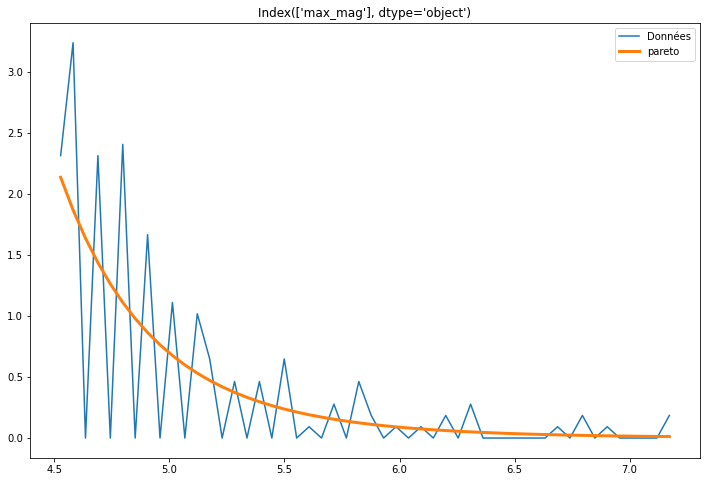

Selected Model :  pareto
Loc. param. :  -0.031223002619940876
Scale param. :  4.531223002598799
Other arguments :  (10.359695680676117,)
SSE :  12.611890865847402


In [19]:

params_depth = estim_best_loi(dicos_zones_max_mag['A'].max_mag) # pour la zone A

Sans determination de $b_{n}$ et  $a_{n}$, cad à partant juste de $ M_{k}^{q}$, alors la loi de **Pareto** semble être celle qui modélise le mieux notre distribution de $ M_{k}^{q}$


# Modelisation fréquence

In [20]:
#seuil_sinistre = 5
#data['claims'] = data['class']>= seuil_sinistre # on definit une variable sinistre
#data.head()

# On regroupe les observations par mois et on compte le nombre de EQ dans le mois
temp2 = data.groupby(['year','month','zone'], as_index = False)
df_nb_per_month_per_zone = temp2.mag.count()
df_nb_per_month_per_zone.rename({"mag":"nb_EQ"},axis=1,inplace=True)
df_nb_per_month_per_zone.tail() 

,year,month,zone,nb_EQ
2874,2021,12,A,7
2875,2021,12,B,5
2876,2021,12,C,4
2877,2021,12,D,1
2878,2021,12,G,1


In [21]:
#On divise la base en zone et on enregistre toutes ces zones dans une 
dicos_zones_nb_EQ ={name:data for name, data in zip(zones.keys(),
                                              [df_nb_per_month_per_zone[df_nb_per_month_per_zone['zone']== k] 
                                               
                                               for k in df_nb_per_month_per_zone['zone'].unique()])}

## Poisson

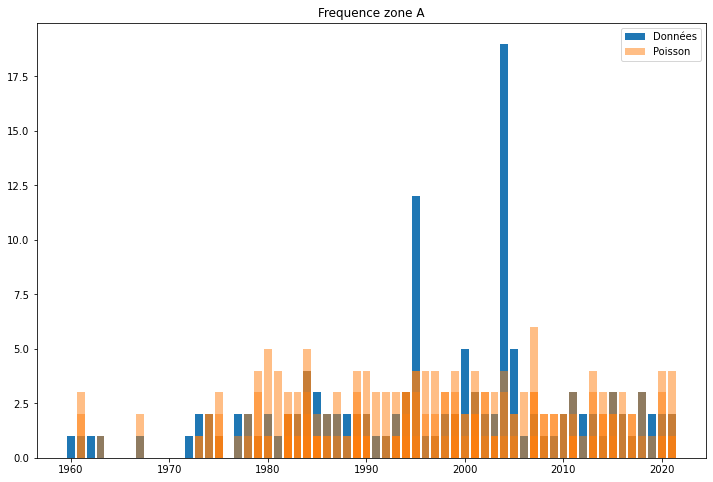

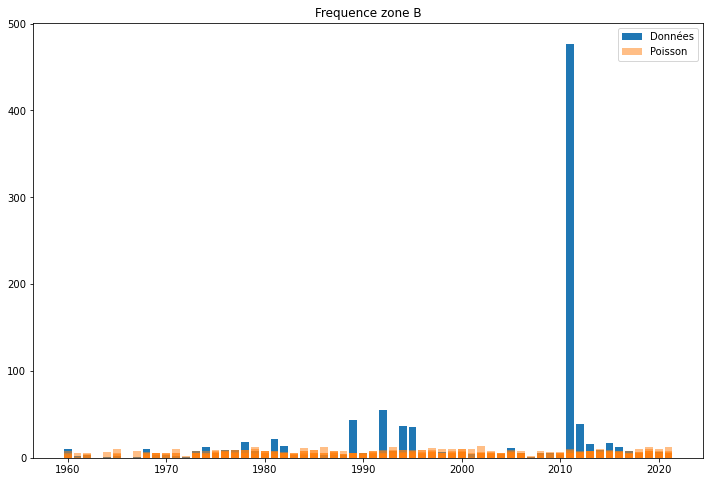

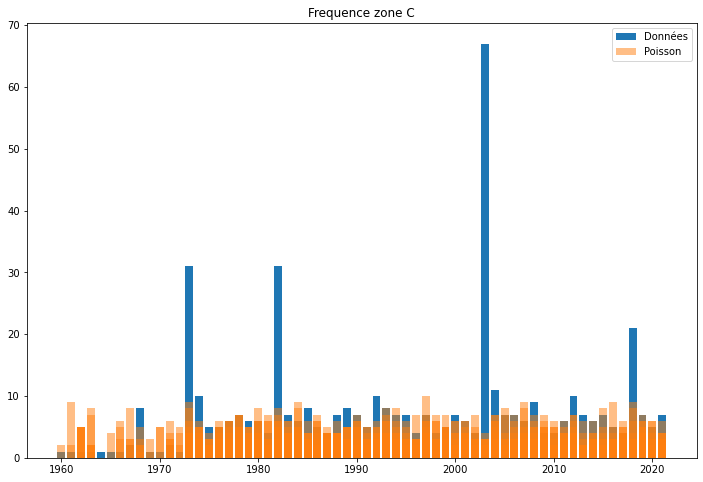

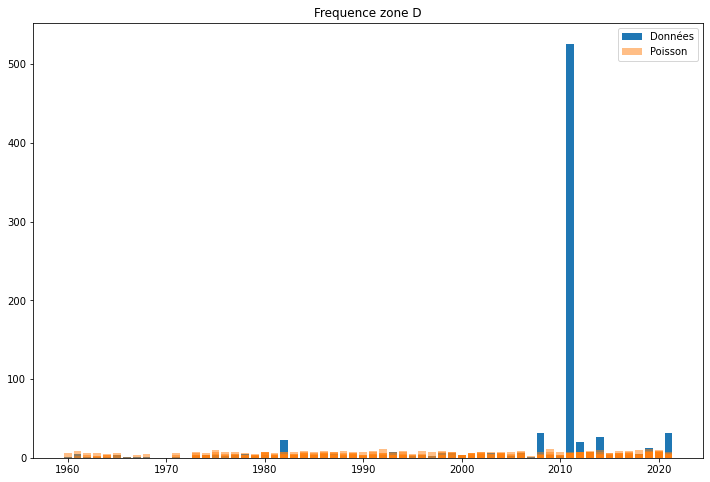

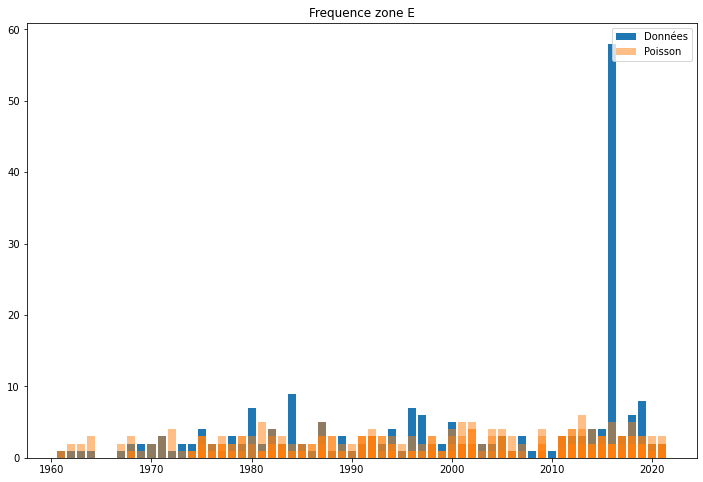

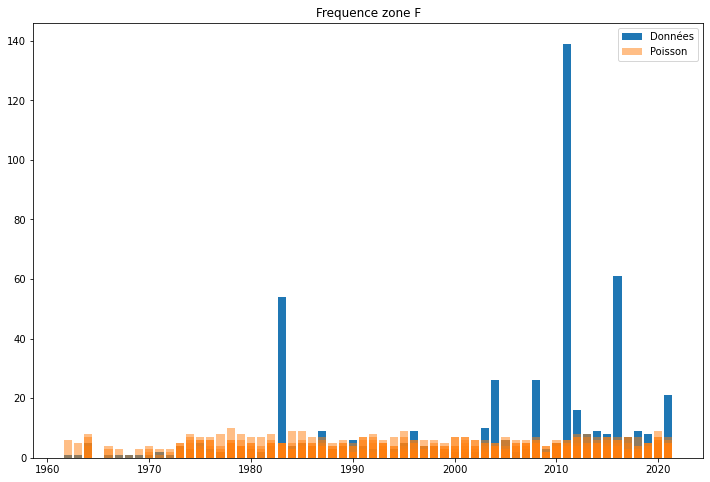

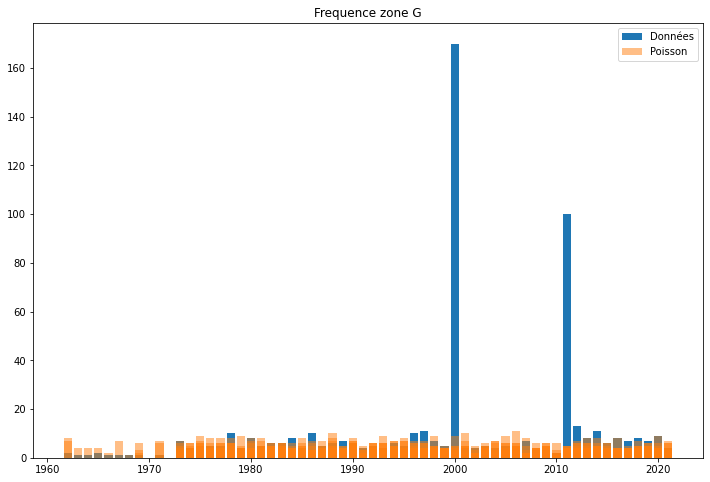

In [22]:

for zone in zones.keys():   
    mu = np.mean(dicos_zones_nb_EQ[zone].nb_EQ)
    pmf=scipy.stats.poisson.rvs(mu=mu,size=len(dicos_zones_nb_EQ[zone].nb_EQ))
    plt.figure(figsize=(12,8))
    plt.bar(dicos_zones_nb_EQ[zone].year,height=dicos_zones_nb_EQ[zone].nb_EQ,label="Données")
    plt.bar(dicos_zones_nb_EQ[zone].year, pmf, label="Poisson",alpha=0.5)
    plt.legend(loc='upper right')
    plt.title("Frequence zone {}".format(zone))
    plt.show()
    

# 

## Negative binomial modelling

**Si jamais une regression est envisagée dans le futur, il serait d'installer ce module qui donne plus de possibilités
#conda install -c conda-forge statsmodels**

In [67]:
# pour mettre à jour le module

# conda update -n base -c defaults conda


Windows 64-bit packages of scikit-learn can be accelerated using scikit-learn-intelex.
    More details are available here: https://intel.github.io/scikit-learn-intelex

    For example:

        $ conda install scikit-learn-intelex
        $ python -m sklearnex my_application.py


done

Site intéressant pour se documenter sur le module statsmodels

https://www.statsmodels.org/dev/examples/index.html

### Essai de modelisation statistiques

In [24]:
#"""On implemente les estimateurs de maximum de Vraissemblance des params mu et r, ref doc de Boussim """"
#Pour la zone A par exemple

zone = 'A'
sigma = (len(dicos_zones_nb_EQ[zone].nb_EQ)/len(dicos_zones_nb_EQ[zone].nb_EQ)-1)*np.var(dicos_zones_nb_EQ[zone].nb_EQ)
mu = np.mean(dicos_zones_nb_EQ[zone].nb_EQ)
p = 1 - (sigma)/mu
r = mu**2 / (sigma - mu)


Il faut maintenant utiliser ces paramètres pour créer une densité qui s'approche de la densité de notre distribution.

Ce site peut aider :
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html